In [1]:
import torch
from torch import distributions as dist
from matplotlib import pyplot as plt

In [2]:
# Hack to import from a parent directory
import sys
path = '..'
if path not in sys.path:
    sys.path.append(path)

from LogitNormal import *

## Logit normal distribution

The pdf of the (scaled) logit normal distribution with location $\mu$, scale $\sigma$, and scaling bounds $a$ and $b$, for $x \in (a, b)$ is:
$$
p(x; \mu, \sigma, a, b) = \phi \left( \text{logit}\left(\frac{x-a}{b-a}\right); \mu, \sigma^2 \right)
    \frac{b-a}{(x-a)(b-x)}
$$

where $\phi(\cdot; \mu, \sigma^2)$ is the pdf of the normal distribution with mean $\mu$ and variance $\sigma^2$.

The location parameter $\mu$ and the scale parameter $\sigma$ are the mean and standard deviation of the parent normal distribution, **not** those of the resulting logit normal distribution.

## Multivariate logit normal distribution

Given location vector $\mu \in \mathbb{R}^n$, positive definite (parent) covariance matrix $\Sigma \in \mathbb{R}^{n \times n}$, and scaling bounds $a \in \mathbb{R}^n$ and $b \in \mathbb{R}^n$, the $n$-dimensional random vector $x$ is a multivariate logit normal distribution (with independent scaling $x_i \in (a_i, b_i)$ for $i=1, ..., n$) if:

$$p(x; \mu, \Sigma, a, b) = \Phi(\tilde{x}; \mu, \Sigma) \prod_i \frac{b_i-a_i}{(x_i-a_i)(b_i-x_i)}$$

where $\tilde{x} = \left[ \text{logit}\left(\frac{x_1-a_1}{b_1-a_1}\right), ..., \text{logit}\left(\frac{x_n-a_n}{b_n-a_n}\right) \right]$ and $\Phi(\cdot; \mu, \Sigma)$ is the pdf of the multivariate normal distribution with mean vector $\mu$ and covariance matrix $\Sigma$.

With reparameterized sampling `rsample` from the multivariate normal distribution already implemented in PyTorch, all we have to do is:
- $x' \sim$ `MultivariateNormal.rsample` $(\mu, \Sigma)$
- $x_i = (b_i-a_i)\text{sigmoid}(x_i') + a_i$

Is the marginal distribution of $x_i$ a logit normal distribution with location $\mu_i$ and scale $\sqrt{\Sigma_{ii}}$?
$$
p(x_i; \mu, \Sigma, a, b) = \phi \left( \text{logit}\left(\frac{x_i-a_i}{b_i-a_i}\right); \mu_i, \Sigma_{ii} \right)
    \frac{b_i-a_i}{(x_i-a_i)(b_i-x_i)}
$$
We will verify this using simple Monte Carlo sampling.

## Toy model

Let $x \sim \text{MultivariateNormal}(\mu_x, \Sigma_x)$. Given fixed $x, \mu_\theta, \Sigma_\theta, a, b$, the generative process of our toy model is:
- $\theta \sim \text{MultivariateLogitNormal}(\mu_\theta, \Sigma_\theta, a, b)$
- $y_i \sim \text{Bernoulli}(\sigma(\theta^T x_i + \theta_0)), i = 1, ..., N$

We would like to infer approximate posterior $q(\theta)$ in the same way $\theta$ inference is done in the SDEFlow framework:
- for each iteration $n=1, ..., N$:
  - for each sample $s=1, ..., S$: $\theta^{(s)} \sim q(\theta)$
  - `loss` $= -\frac{1}{S} \sum_s \left[\log p(\theta^{(s)}) + \log p(y|\theta^{(s)}) - \log q(\theta^{(s)})\right]$ 
  - `loss.backward()`

### Generate data
As a first trial, let's consider $D=3, N = 20$ and independent priors.

In [3]:
def generate_data(N, mu_x, sigma_x, mu_theta, sigma_theta, a_theta, b_theta):
    # Sample x
    x_dist = dist.multivariate_normal.MultivariateNormal(mu_x, sigma_x)
    x = x_dist.sample((N, )) # (N, D)
    
    # Concat with 1 for bias term
    x_cat = torch.cat((torch.ones((N, 1)), x), 1) # (N, D+1)
    
    # Sample theta
    theta_dist = MultivariateLogitNormal(mu_theta, sigma_theta, a=a_theta, b=b_theta)
    theta = theta_dist.sample() # (D+1, ) including bias term
    
    # Sample y
    p = torch.sigmoid(x_cat @ theta)
    y_dist = dist.bernoulli.Bernoulli(p)
    y = y_dist.sample() # (N, )
    
    return x_cat, y, theta_dist, theta

In [4]:
N, D = 20, 3
mu_x = torch.tensor([0., -5., 10.])
sigma_x = torch.eye(D)
mu_theta = torch.tensor([-2., 0., -0.2, 1.]) # (bias, theta1, theta2, theta3)
sigma_theta = torch.diag(torch.tensor([1, 1, 0.2, 1]))
a_theta = torch.tensor([-10, 0, -10, -10])
b_theta = torch.tensor([10, 100, 20, 10])

x, y, p_theta, theta = generate_data(N, mu_x, sigma_x, mu_theta, sigma_theta, a_theta, b_theta)
y

tensor([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
        1., 1.])

### Inference

In [5]:
class MeanField(nn.Module):
    def __init__(self, init_loc, init_scale_tril, lower_bounds, upper_bounds):
        super().__init__()
        self.dist = MultivariateLogitNormal
        self.loc = nn.Parameter(1.0 * init_loc) # (D + 1, )
        unconstrained_scale_tril = dist.transform_to(self.dist.arg_constraints['scale_tril']).inv(init_scale_tril)
        self.unconstrained_scale_tril = nn.Parameter(unconstrained_scale_tril) # (D + 1, D + 1)
        self.lower = lower_bounds
        self.upper = upper_bounds

    def forward(self, N=10):
        # Update posterior
        parent_loc = self.loc
        parent_scale_tril = dist.transform_to(self.dist.arg_constraints['scale_tril'])(self.unconstrained_scale_tril)
        q_dist = self.dist(parent_loc, scale_tril=parent_scale_tril, a = self.lower, b = self.upper)

        # Sample theta ~ q(theta).
        samples = q_dist.rsample((N, )) # (N, num_params)
        
        # Evaluate log prob of theta samples.
        log_q_theta = q_dist.log_prob(samples) # (N, )
        
        #Return samples in dictionary and tensor format.                                
        #return dict_out, samples, log_q_theta, dict_parent_loc_scale, dict_mean_sd
        return samples, log_q_theta

In [18]:
def train(x, y, p_theta, lr, num_iters, batch_size=10, print_every=10):
    q_theta = MeanField(p_theta.loc, p_theta.scale_tril, p_theta.a, p_theta.b)
    optimizer = torch.optim.Adam(q_theta.parameters(), lr=lr)
    loss_hist = []
    N, D = x.shape
    for i in range(num_iters):
        optimizer.zero_grad()
        
        # Sample theta and compute log q(theta)
        theta, log_post = q_theta(batch_size)
        assert theta.shape == (batch_size, D)
        assert log_post.shape == (batch_size, )
        
        # Compute log p(theta)
        log_prior = p_theta.log_prob(theta) # (batch_size, )
        assert log_prior.shape == (batch_size, )
        
        # Compute log p(y|theta; x)
        p_y = dist.bernoulli.Bernoulli(torch.sigmoid(theta @ x.T)) # p_y.probs.shape == (batch_size, N)
        log_lik = p_y.log_prob(y.reshape((1, -1))).sum(-1) # (batch_size, N) -> (batch_size, )
        assert log_lik.shape == (batch_size, )
        
        # Compute negative ELBO: -(log p(theta) + log p(y|theta; x) - log q(theta)).mean()
        loss = -log_prior.mean() - log_lik.mean() + log_post.mean()
        loss_hist.append(loss)
        if i%print_every == 0:
            print('Iteration {} loss: {}'.format(i, loss))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(q_theta.parameters(), 3.0)
        optimizer.step()
        
    return q_theta, loss_hist

In [19]:
q_theta, loss_hist = train(x, y, p_theta, 0.05, 200, batch_size=100)

Iteration 0 loss: 99.86798095703125
Iteration 10 loss: 44.48919677734375
Iteration 20 loss: 29.23321533203125
Iteration 30 loss: 16.973876953125
Iteration 40 loss: 10.31854248046875
Iteration 50 loss: 8.64251708984375
Iteration 60 loss: 6.24212646484375
Iteration 70 loss: 5.63299560546875
Iteration 80 loss: 5.22247314453125
Iteration 90 loss: 4.6917724609375
Iteration 100 loss: 4.89208984375
Iteration 110 loss: 5.10638427734375
Iteration 120 loss: 4.7213134765625
Iteration 130 loss: 5.069580078125
Iteration 140 loss: 4.6466064453125
Iteration 150 loss: 4.39984130859375
Iteration 160 loss: 4.4193115234375
Iteration 170 loss: 4.51702880859375
Iteration 180 loss: 4.42474365234375
Iteration 190 loss: 4.36968994140625


### Visualizations

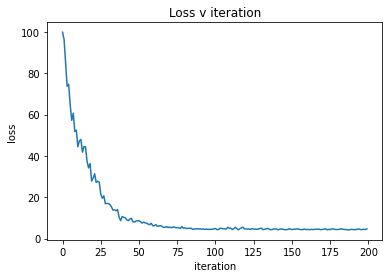

In [23]:
def plot_loss(loss_hist):
    plt.plot(loss_hist)
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.title('Loss v iteration')
    
plot_loss(loss_hist)

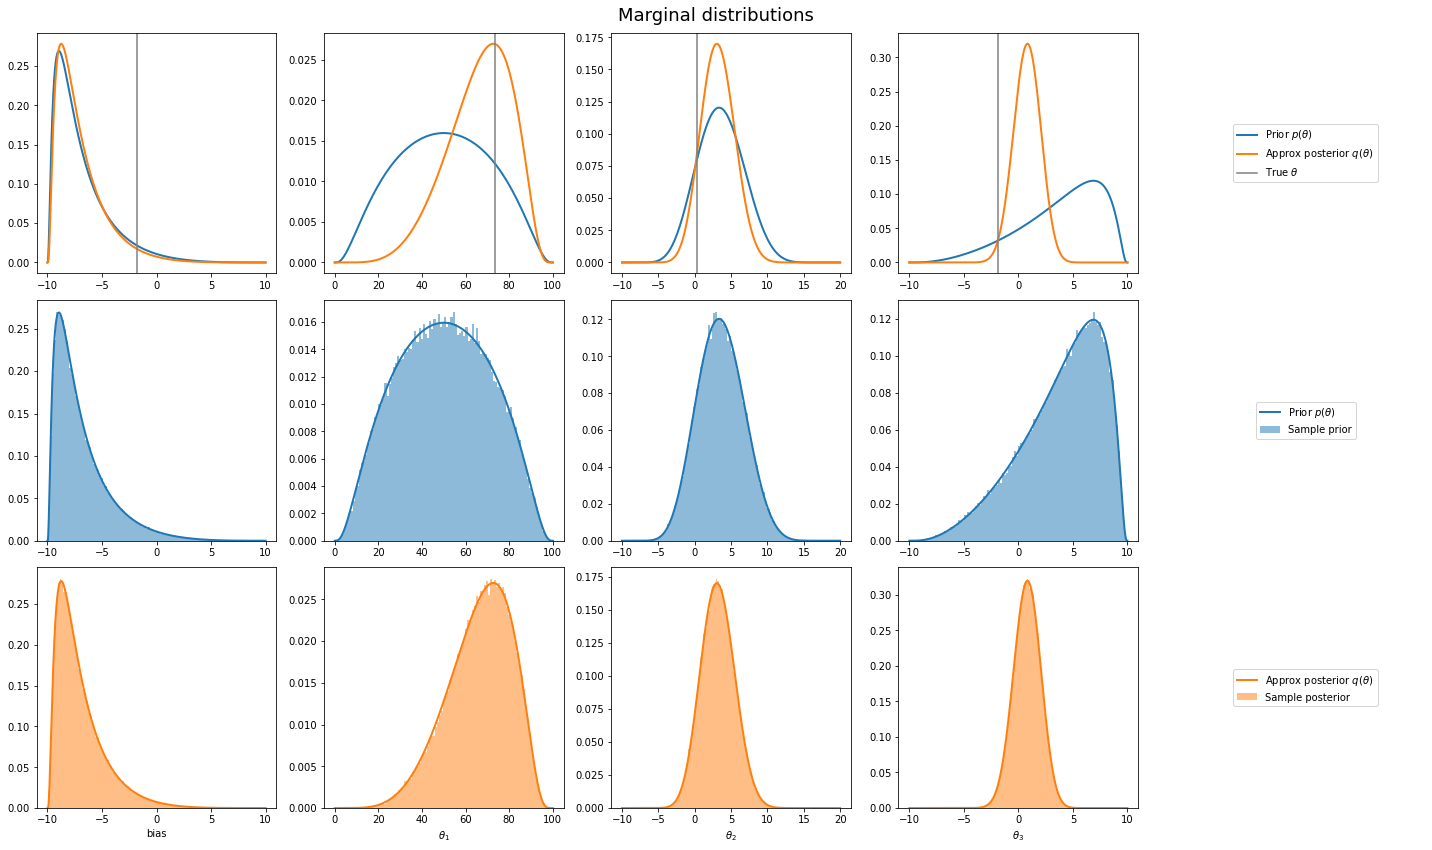

In [89]:
def plot_theta(p_theta, q_theta, num_pts=100000, num_samples=100000, bins=100, eps=1e-5):
    a, b = p_theta.a, p_theta.b
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    
    # Prior
    scale_prior = torch.diag(p_theta.covariance_matrix).sqrt()
    marg_prior_dist = RescaledLogitNormal(p_theta.loc, scale_prior, a=a, b=b)
    marg_prior = torch.exp(marg_prior_dist.log_prob(theta_range)).detach()
    approx_int_prior = marg_prior.sum(0) * (b - a) / num_pts
    assert torch.all(torch.isclose(torch.ones([]), approx_int_prior))
    
    # Posterior
    loc_post = q_theta.loc
    scale_tril_post = dist.transform_to(q_theta.dist.arg_constraints['scale_tril'])(q_theta.unconstrained_scale_tril)
    post_dist = q_theta.dist(loc_post, scale_tril=scale_tril_post, a=a, b=b)
    scale_post = torch.diag(post_dist.covariance_matrix).sqrt()
    marg_post_dist = RescaledLogitNormal(loc_post, scale_post, a=a, b=b)
    marg_post = torch.exp(marg_post_dist.log_prob(theta_range)).detach()
    approx_int_post = marg_post.sum(0) * (b - a) / num_pts
    assert torch.all(torch.isclose(torch.ones([]), approx_int_post))
    
    # Plot prior & posterior vs true theta
    D = len(loc_post)
    fig, axes = plt.subplots(3, D+1, figsize=(4*(D+1), 4*3))
    for i, ax in enumerate(axes[0]):
        #print(i, D)
        if i < D:
            ax.plot(theta_range[:, i], marg_prior[:, i], label='Prior $p(\\theta)$', color='tab:blue', linewidth=2)
            ax.plot(theta_range[:, i], marg_post[:, i], label='Approx posterior $q(\\theta)$', color='tab:orange', linewidth=2)
            ax.axvline(theta[i], color='gray', label='True $\\theta$')
        else:
            handles, labels = axes[0, 0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center')
            ax.axis('off')
            
    # Plot prior vs empirical prior
    assert isinstance(p_theta, MultivariateLogitNormal)
    prior_samples = p_theta.sample((num_samples, ))
    for i, ax in enumerate(axes[1]):
        if i < D:
            ax.hist(np.array(prior_samples[:, i]), bins=bins, density=True, label='Sample prior', color='tab:blue', alpha=0.5)
            ax.plot(theta_range[:, i], marg_prior[:, i], label='Prior $p(\\theta)$', color='tab:blue', linewidth=2)
        else:
            handles, labels = axes[1, 0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center')
            ax.axis('off')
    
    # Plot posterior vs empirical posterior
    assert isinstance(post_dist, MultivariateLogitNormal)
    post_samples = post_dist.sample((num_samples, )) # (N, D)
    xlabels = ['bias', '$\\theta_1$', '$\\theta_2$', '$\\theta_3$']
    for i, ax in enumerate(axes[2]):
        if i < D:
            ax.hist(np.array(post_samples[:, i]), bins=bins, density=True, label='Sample posterior', color='tab:orange', alpha=0.5)
            ax.plot(theta_range[:, i], marg_post[:, i], label='Approx posterior $q(\\theta)$', color='tab:orange', linewidth=2)
            ax.set_xlabel(xlabels[i])
        else:
            handles, labels = axes[2, 0].get_legend_handles_labels()
            ax.legend(handles, labels, loc='center')
            ax.axis('off')
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.95)
    fig.suptitle('Marginal distributions', fontsize=18)
    
plot_theta(p_theta, q_theta)

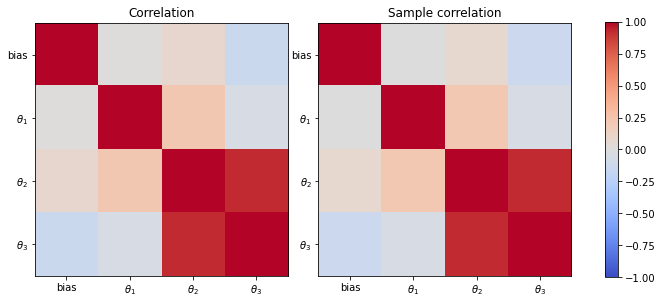

In [90]:
def plot_corr(q_theta, num_samples=100000):
    a, b = q_theta.lower, q_theta.upper
    theta_range = torch.from_numpy(np.linspace(a + eps, b - eps, num_pts)).float()
    loc_post = q_theta.loc
    scale_tril_post = dist.transform_to(q_theta.dist.arg_constraints['scale_tril'])(q_theta.unconstrained_scale_tril)
    post_dist = q_theta.dist(loc_post, scale_tril=scale_tril_post, a=a, b=b)
    scale_post = torch.diag(post_dist.covariance_matrix).sqrt()
    marg_post_dist = RescaledLogitNormal(loc_post, scale_post, a=a, b=b)
    marg_post = torch.exp(marg_post_dist.log_prob(theta_range)).detach()
    approx_int_post = marg_post.sum(0) * (b - a) / num_pts
    assert torch.all(torch.isclose(torch.ones([]), approx_int_post))
    
    # Calculate correlation
    corr = post_dist.covariance_matrix / torch.outer(scale_post, scale_post)
    
    # Calculate empirical correlation
    assert isinstance(post_dist, MultivariateLogitNormal)
    post_samples = post_dist.sample((num_samples, )) # (N, D)
    corr_mc = np.corrcoef(post_samples.T)
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(5*2, 5*1))
    labels = ['bias', '$\\theta_1$', '$\\theta_2$', '$\\theta_3$']
    D = len(loc_post)
    corr_list = [corr.detach(), corr_mc]
    titles = ['Correlation', 'Sample correlation']
    for i, ax in enumerate(axes):
        plot = ax.imshow(corr_list[i], cmap='coolwarm', vmin=-1, vmax=1)
        ax.set_xticks(range(D))
        ax.set_xticklabels(labels)
        ax.set_yticks(range(D))
        ax.set_yticklabels(labels)
        ax.set_title(titles[i])
        
    plt.tight_layout()
    plt.colorbar(plot, ax=axes, shrink=0.8)
    plt.show()
    
plot_corr(q_theta)

### Notes on `scale_tril` constraint

In [94]:
scale_tril = torch.diag(torch.arange(1, 5))
scale_tril

tensor([[1, 0, 0, 0],
        [0, 2, 0, 0],
        [0, 0, 3, 0],
        [0, 0, 0, 4]])

In [95]:
constraint = dist.multivariate_normal.MultivariateNormal.arg_constraints['scale_tril']

In [100]:
unconstrained_scale_tril = dist.transform_to(constraint).inv(scale_tril)

In [102]:
scale_tril = dist.transform_to(constraint)(unconstrained_scale_tril)
scale_tril

tensor([[1., 0., 0., 0.],
        [0., 2., 0., 0.],
        [0., 0., 3., 0.],
        [0., 0., 0., 4.]])

Without this inverse transformation at initialization, the constrained values of `scale_tril` used at the first inference iteration would be **incorrect** (i.e. initialization won't actually match prior/whatever we think we init it with):

In [103]:
dist.transform_to(constraint)(scale_tril)

tensor([[ 2.7183,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  7.3891,  0.0000,  0.0000],
        [ 0.0000,  0.0000, 20.0855,  0.0000],
        [ 0.0000,  0.0000,  0.0000, 54.5982]])

In [113]:
from TruncatedNormal import *

In [114]:
rv = TruncatedNormal(-2, 2, a=0, b=10)
samples = rv.sample((10,))
log_probs = rv.log_prob(samples)
samples, log_probs

(tensor([0.7947, 1.9265, 0.3625, 0.2779, 4.4668, 1.2913, 0.5757, 0.9806, 1.3533,
         0.0907]),
 tensor([-0.7474, -1.6982, -0.4687, -0.4197, -4.9985, -1.1251, -0.6004, -0.8815,
         -1.1767, -0.3174]))

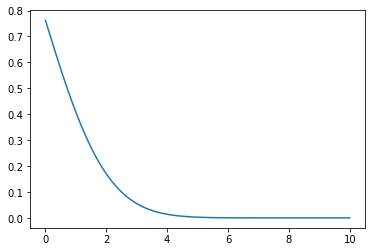

In [115]:
num_pts = 1000
pts = torch.linspace(0, 10, num_pts)
pdf = torch.exp(rv.log_prob(pts))
plt.plot(pts, pdf)

In [121]:

loc, scale = -100, 0.00001
a = (a - loc) / scale
b = (b - loc) / scale
a < b

True